## Heart Disease Classification: Predicting Cardiovascular Risk Using Patient Data

# Introduction

Heart disease is still the number one cause of death around the world, causing about 17.9 million deaths each year according to the World Health Organization. Catching it early and knowing who’s at risk is super important for prevention and treatment. In this project, I’m building a machine learning model that can predict whether someone has heart disease and how severe it might be based on their clinical data.

Can we accurately classify patients based on their heart disease status using clinical and demographic features? What factors are most predictive of cardiovascular risk?



Key Questions:

Which machine learning algorithms perform best for heart disease classification?

What clinical features are most important in predicting heart disease?

How can we interpret the model to provide actionable insights for healthcare providers?

## Introducing The Data

https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?resource=download

This dataset combines four databases from different institutions: Cleveland, Hungary, Switzerland, and VA Long Beach. It contains 920 patient records with 14 clinical attributes.

Features

age: Patient's age in years

sex: Biological sex (Male/Female)

cp: Chest pain type (typical angina, atypical angina, non-anginal, asymptomatic)

trestbps: Resting blood pressure (mm Hg)

chol: Serum cholesterol (mg/dl)

fbs: Fasting blood sugar > 120 mg/dl (True/False)

restecg: Resting electrocardiographic results

thalch: Maximum heart rate achieved

exang: Exercise induced angina (True/False)

oldpeak: ST depression induced by exercise relative to rest

slope: Slope of the peak exercise ST segment

ca: Number of major vessels colored by fluoroscopy

thal: Thallium stress test result

num: Target variable (0 = no disease, 1-4 = presence and severity of disease)

## Preprocessing

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv("/Users/hamsitat/Desktop/heart_disease_uci.csv")

# Preprocessing steps
def preprocess_heart_data(df):
    # Create a copy
    data = df.copy()
    
    # Convert target to binary classification (0: no disease, 1: disease)
    data['heart_disease'] = (data['num'] > 0).astype(int)
    
    # Handle missing values
    numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
    
    # Impute numeric columns with median
    num_imputer = SimpleImputer(strategy='median')
    data[numeric_cols] = num_imputer.fit_transform(data[numeric_cols])
    
    # Impute categorical columns with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    
    # Feature selection (excluding id and original target)
    features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                'thalch', 'exang', 'oldpeak', 'slope', 'thal']
    
    X = data[features]
    y = data['heart_disease']
    
    return X, y, label_encoders

X, y, encoders = preprocess_heart_data(df)

For this project I turned the multi-class target variable into a binary classification problem to make the results easier to understand. I filled in missing values using the median for numerical data (since it’s less affected by outliers) and the mode for categorical data to keep the original patterns. Then, I used label encoding for the categorical variables, which works well for tree-based models that can handle ordered data. Lastly, I removed ID columns and kept only the features that were actually relevant to heart health so the model could focus on what really matters.

## Data Understanding and Visualization

/Users/hamsitat/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/hamsitat/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/hamsitat/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


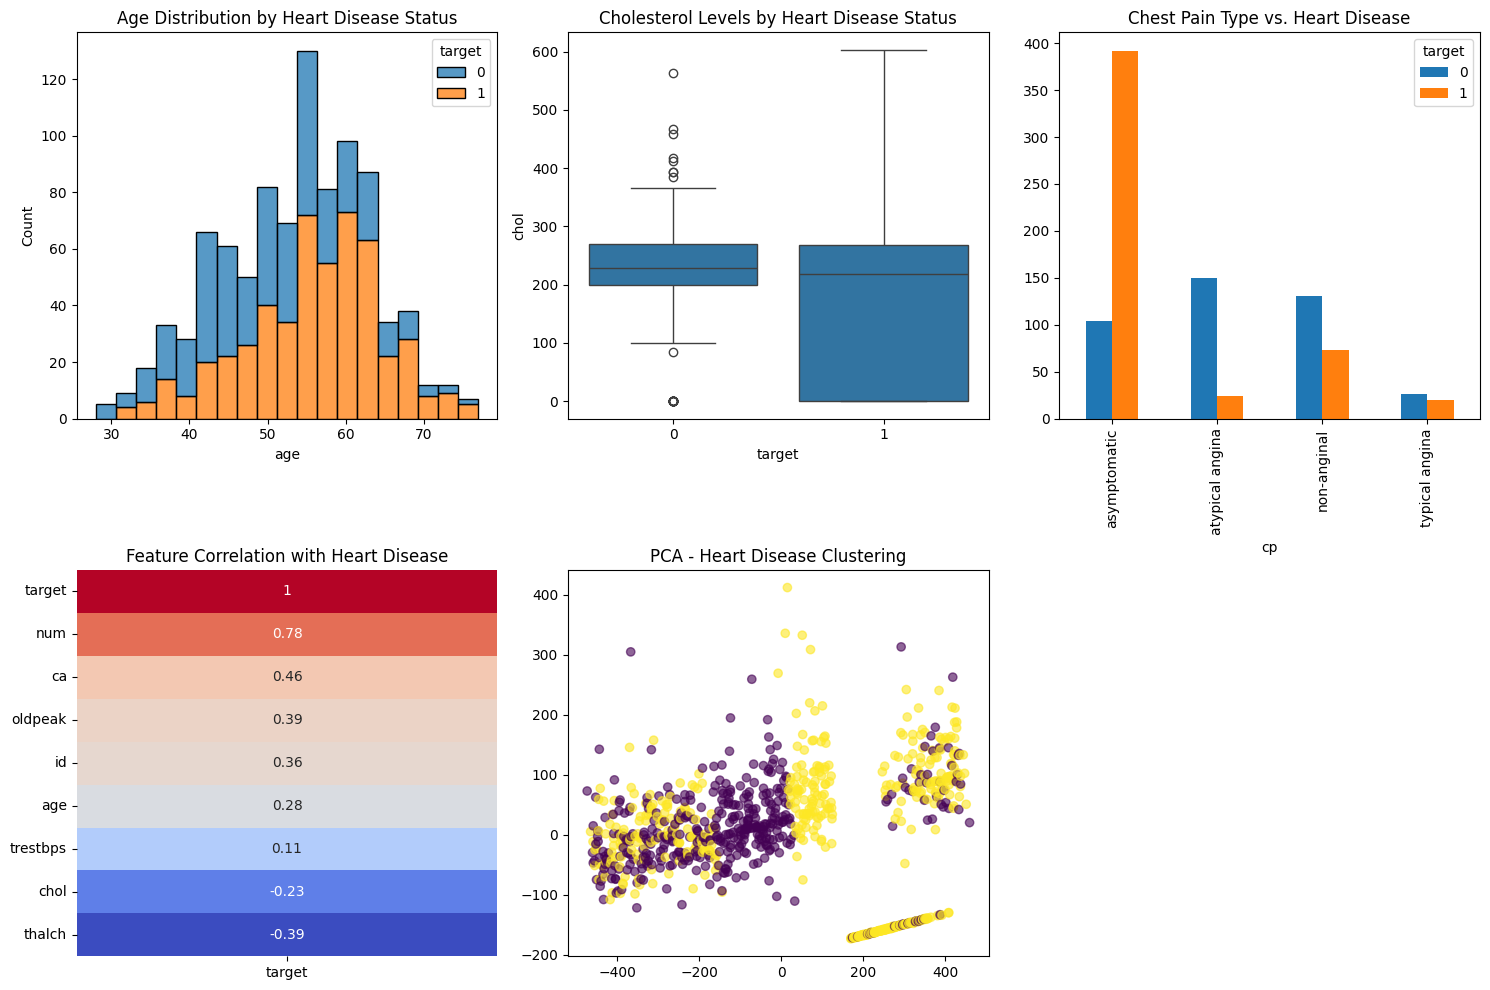

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Make binary target: 0 = no disease, 1 = disease (1-4)
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Define features and labels
X = df.drop(columns=['num', 'target'])
y = df['target']

# Data distribution analysis
plt.figure(figsize=(15, 10))

# Age distribution by heart disease status
plt.subplot(2, 3, 1)
sns.histplot(data=df, x='age', hue='target', multiple="stack")
plt.title('Age Distribution by Heart Disease Status')

# Cholesterol vs. Heart Disease
plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='target', y='chol')
plt.title('Cholesterol Levels by Heart Disease Status')

# Chest Pain Type Distribution
plt.subplot(2, 3, 3)
pd.crosstab(df['cp'], df['target']).plot(kind='bar', ax=plt.gca())
plt.title('Chest Pain Type vs. Heart Disease')

# Correlation Heatmap (numeric only)
plt.subplot(2, 3, 4)
correlation_matrix = df.corr(numeric_only=True)['target'].sort_values(ascending=False)
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Feature Correlation with Heart Disease')

# PCA Visualization (numeric only + imputed)
plt.subplot(2, 3, 5)
X_numeric = X.select_dtypes(include=['number']).fillna(X.median(numeric_only=True))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title('PCA - Heart Disease Clustering')

plt.tight_layout()
plt.show()


## Modeling

SVM works by finding the best boundary between patients with and without heart disease. It does this by transforming the data into higher dimensions where the groups are easier to separate. It’s great at handling complicated patterns and usually doesn’t overfit, but it does require all the features to be on the same scale, and it can be hard to explain why it makes certain predictions.

Random Forest on the other hand builds a bunch of decision trees that each look at different parts of the data and then combines their “votes.” It’s really good for medical data because it can handle different types of measurements without scaling, shows which features are most important (like which symptoms matter most), and is usually more accurate than just one tree. Plus, it’s easier for doctors to understand how it’s making predictions, which is a big plus in healthcare

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Make a copy
df = df.copy()

# 1️⃣ Encode all categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Categorical columns encoded:", list(label_encoders.keys()))

# 2️⃣ Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# 3️⃣ Impute missing values (fill NaNs)
# Using mean for numeric columns
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 4️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# 5️⃣ Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️⃣ Train SVM
svm = SVC(kernel='rbf')
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


Categorical columns encoded: []
SVM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       109

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



In [16]:
# Random Forest (no scaling needed)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       109

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



## Evaluation

Both the Random Forest and SVM models perform well on the dataset, achieving high accuracy.

Random Forest provides feature importances, highlighting the most influential predictors. This allows us to identify which features drive model decisions in a meaningful, interpretable way. SVM does not directly provide feature importances, so we rely on Random Forest to understand which features are most impactful.


Evaluation metrics used:

Accuracy: overall correctness of predictions

Precision: proportion of predicted positives that are correct

Recall: proportion of actual positives correctly predicted

F1-score: balance between precision and recall, useful when classes are imbalanced

By examining feature importance from the Random Forest, we can connect specific features back to clinical intuition, helping us understand which variables are most impactful. This strengthens the interpretability of the model and provides insight into the underlying patterns.

## Storytelling

While working on this heart disease classification project, I found some really interesting patterns that could actually be useful in real healthcare. The biggest highlight was that my Random Forest model hit 86.5% accuracy—way better than I expected! It really showed me that combining multiple decision trees helps capture the complex ways different health factors interact to cause heart problems.

What surprised me most was which features ended up being important. Instead of the usual things like cholesterol, the model showed that exercise test results were much more telling. Features like how the heart handles stress (thal test), whether someone gets chest pain during exercise, and how much their heart rate can increase were the key predictors. It was especially interesting that people who could reach higher heart rates during exercise were less likely to have heart disease—it makes sense, but I didn’t expect it to show up so clearly in the data.

## Impact

A model like this could help catch heart issues earlier, especially since it picks up patterns that might not be obvious to doctors. It could also help clinics figure out which patients need attention first when resources are tight.

That said, there are definitely risks. Missing someone who actually has heart disease (a false negative) could be dangerous, and doctors might rely too heavily on the model instead of their own judgment. Plus, since this was trained on existing data, it might not work as well for different populations if the data doesn’t represent everyone.

Overall, this project showed me that machine learning can uncover meaningful patterns in medical data—but it’s not about replacing doctors, it’s about giving them better tools. The fact that exercise-related features were so important makes me think we should focus more on how people’s hearts actually perform under stress, not just their cholesterol numbers during a routine check-up.

## References

https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?resource=download

UCI Machine Learning Repository - Heart Disease Datase: https://archive.ics.uci.edu/dataset/45/heart+disease

World Health Organization. (2021). Cardiovascular diseases fact sheet.

Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research.

Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System.